<a href="https://colab.research.google.com/github/Reptilefury/coursera-machine-learning/blob/main/Transfer_Learning_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',origin=_URL,extract = True)
path = os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')


train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path,'validation')

batch_size = 32
image_size= (160,160)


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    shuffle = True,
    batch_size = batch_size,
    image_size = image_size
)


validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle = True,
    batch_size = batch_size, 
    image_size = image_size, 
)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL ='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL,extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')

BATCH_SIZE = 32

image_width = 160 
image_height = 160 

IMAGE_SIZE = (image_width, image_height)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle = True, 
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle = True, 
    batch_size = BATCH_SIZE, 
    image_size = image_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set

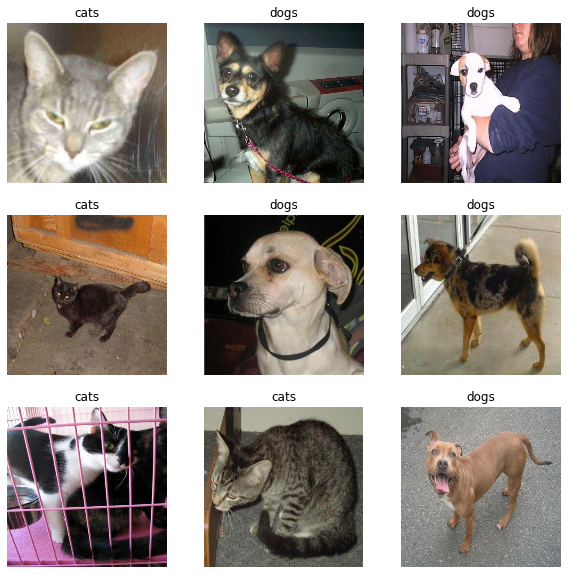

In [ ]:
class_names = train_dataset.class_names
fig = plt.figure(figsize =(10,10))
for image_batch,label_batch in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i +1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[i]])

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches //5) 
validation_dataset = validation_dataset.skip(val_batches//5)
print("The number of validation batches %d" %tf.data.experimental.cardinality(validation_dataset))
print("The number of  test batches %d" % tf.data.experimental.cardinality(test_dataset))

The number of validation batches 26
The number of  test batches 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)

test_dataset =  test_dataset.prefetch(buffer_size = AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2)
])

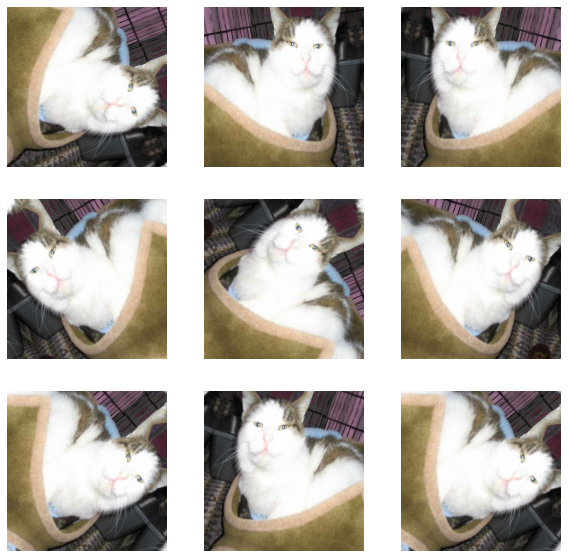

In [ ]:
#Visualize the augemnted image
for image,_ in train_dataset.take(1):
  plt.figure(figsize =(10,10))
  first_image = image[1]
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.axis('off')
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0]/255.0)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5,offset =-1)

In [ ]:
IMAGE_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,weights='imagenet',include_top= False) #Feature learning part of our network

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch,label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
#lets freeze the weights of the base model so that the learning algorithm won't update them during training
base_model.trainable = False #By setting this to false we have frozen the weights of all the layers of our convolution block 
#so the learning algorithm won't affect the weights of these layers also incase there is a batch Normalization layer
#it will run in inference mode so the it won't update its mean and variance statistics.

#Below is a summary of our base model (Convolution block)
#base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
#Make a  batch prediction
batch_pred = prediction_layer(feature_batch_average)
print(batch_pred.shape) #One logit

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training =False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

base_learning_rate = 1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss = tf.keras.losses.BinaryCrossentropy(from_logits= True),metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
loss0,accuracy0 = model.evaluate(validation_dataset)

print("initial loss {:.2f}".format(loss0))
print("initial accuracy  {:.2f}".format(accuracy0))

26/26 [==============================] - 14s 467ms/step - loss: 0.8371 - accuracy: 0.5000
initial loss 0.84
initial accuracy  0.50


In [ ]:
history = model.fit(train_dataset,batch_size = 32,epochs =initial_epochs, validation_data= validation_dataset,verbose=1,shuffle=True)

Epoch 1/10
63/63 [==============================] - 51s 763ms/step - loss: 0.7227 - accuracy: 0.5550 - val_loss: 0.5344 - val_accuracy: 0.6448
Epoch 2/10
63/63 [==============================] - 46s 731ms/step - loss: 0.5501 - accuracy: 0.6705 - val_loss: 0.3856 - val_accuracy: 0.7809
Epoch 3/10
63/63 [==============================] - 47s 740ms/step - loss: 0.4290 - accuracy: 0.7570 - val_loss: 0.2953 - val_accuracy: 0.8577
Epoch 4/10
63/63 [==============================] - 47s 741ms/step - loss: 0.3618 - accuracy: 0.8205 - val_loss: 0.2424 - val_accuracy: 0.8998
Epoch 5/10
63/63 [==============================] - 46s 736ms/step - loss: 0.3121 - accuracy: 0.8530 - val_loss: 0.2028 - val_accuracy: 0.9282
Epoch 6/10
63/63 [==============================] - 48s 757ms/step - loss: 0.2907 - accuracy: 0.8680 - val_loss: 0.1776 - val_accuracy: 0.9418
Epoch 7/10
63/63 [==============================] - 47s 741ms/step - loss: 0.2654 - accuracy: 0.8860 - val_loss: 0.1615 - val_accuracy: 0.9493

In [ ]:
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label ='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label = 'val loss')
plt.legend(loc = 'center right')